In [1]:
%matplotlib inline


======================================================================================
03. Translation and the NumpyTranslator
======================================================================================

**Suhas Somnath**

8/8/2017

This document illustrates an example of extracting data out of proprietary raw data files and writing the information
into a **Universal Spectroscopy and Imaging Data (USID)** HDF5 file (referred to as a **h5USID** file) using the
``pyUSID.NumpyTranslator``

Introduction
------------

Before any data analysis, we need to access data stored in the raw file(s) generated by the microscope. Often, the
data and parameters in these files are **not** straightforward to access. In certain cases, additional / dedicated
software packages are necessary to access the data while in many other cases, it is possible to extract the necessary
information from built-in **numpy** or similar python packages included with **anaconda**.

The USID model aims to make data access, storage, curation, etc. simply by storing the data along with all
relevant parameters in a single file (HDF5 for now).

The process of copying data from the original format to **h5USID** files is called
**Translation** and the classes available in pyUSID and children packages such as pycroscopy that perform these
operation are called **Translators**

Simply put, so long as one has the metadata and the actual data extracted from the raw data file,
the ``pyUSID.NumpyTranslator`` will correctly write the contents to a h5UID / HDF5 file.
Note that the complexity or size of the raw data may necessitate a custom Translator class. However, the rough process
of translation is the same regardless of the origin, complexity, or size of the raw data:

* Investigating how to open the proprietary raw data file
* Reading the metadata
* Extracting the data
* Writing to h5USID file

The goal of this document is to demonstrate how one would extract data and parameters from a Scanning Tunnelling
Spectroscopy (STS) raw data file obtained from an Omicron Scanning Tunneling Microscope (STM) into a h5USID file.

While there is an `AscTranslator <https://github.com/pycroscopy/pycroscopy/blob/master/pycroscopy/io/translators/omicron_asc.py>`_
available in our sister-package - ``pycroscopy`` that can translate these files in just a **single** line,
we will intentionally assume that no such translator is available. Using a handful of useful functions in pyUSID,
we will translate the files from the source **.asc** format to h5USID files in just a few lines.

The same methodology can be used to translate other data formats

Recommended pre-requisite reading
---------------------------------

Before proceeding with this example, we recommend reading the previous documents to learn more about:

* `Universal Spectroscopic and Imaging Data (USID) model </../../../USID/usid_model.html>`_

.. tip::
    You can download and run this document as a Jupyter notebook using the link at the bottom of this page.

Import all necessary packages
-----------------------------
There are a few setup procedures that need to be followed before any code is written. In this step, we simply load a
few python packages that will be necessary in the later steps.



In [2]:
# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os
import zipfile

# Warning package in case something goes wrong
from warnings import warn
import subprocess
import sys


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip


# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Finally import pyUSID:
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\pycroscopy\lib\site-packages\ipykernel\__main__.py:21: UserWarning: wget not found.  Will install with pip.
C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\pycroscopy\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


Step 0. Procure the Raw Data file
=================================



In [4]:
# Download the compressed data file from Github:
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/STS.zip'
zip_path = 'STS.zip'
# if os.path.exists(zip_path):
#     os.remove(zip_path)
# _ = wget.download(url, zip_path, bar=None)

zip_path = os.path.abspath(zip_path)
# figure out the folder to unzip the zip file to
folder_path, _ = os.path.split(zip_path)
zip_ref = zipfile.ZipFile(zip_path, 'r')
# unzip the file
zip_ref.extractall(folder_path)
zip_ref.close()
# delete the zip file
os.remove(zip_path)

data_file_path = 'STS.asc'

Step 1. Exploring the Raw Data File
====================================

Inherently, one may not know how to read these ``.asc`` files. One option is to try and read the file as a text file
one line at a time.

It turns out that these ``.asc`` files are effectively the standard ``ASCII`` text files.

Here is how we tested to see if the ``asc`` files could be interpreted as text files. Below, we read just the first 10
lines in the file



In [5]:
with open(data_file_path, 'r') as file_handle:
    for lin_ind in range(10):
        print(file_handle.readline())

# File Format = ASCII

# Created by SPIP 4.6.5.0 2016-09-22 13:32

# Original file: C:\Users\Administrator\AppData\Roaming\Omicron NanoTechnology\MATRIX\default\Results\16-Sep-2016\I(V) TraceUp Tue Sep 20 09.17.08 2016 [14-1]  STM_Spectroscopy STM

# x-pixels = 100

# y-pixels = 100

# x-length = 29.7595

# y-length = 29.7595

# x-offset = -967.807

# y-offset = -781.441

# z-points = 500



Step 2. Loading the data
=========================
Now that we know that these files are simple text files, we can manually go through the file to find out which lines
are important, at what lines the data starts etc.
Manual investigation of such ``.asc`` files revealed that these files are always formatted in the same way. Also, they
contain parameters in the first ``403`` lines and then contain data which is arranged as one pixel per row.
STS experiments result in 3 dimensional datasets ``(X, Y, current)``. In other words, a 1D array of current data (as a
function of excitation bias) is sampled at every location on a two dimensional grid of points on the sample.
By knowing where the parameters are located and how the data is structured, it is possible to extract the necessary
information from these files.
Since we know that the data sizes (<200 MB) are much smaller than the physical memory of most computers, we can start
by safely loading the contents of the entire file to memory



In [6]:
# Extracting the raw data into memory
file_handle = open(data_file_path, 'r')
string_lines = file_handle.readlines()
file_handle.close()

Step 3. Read the parameters
==============================
The parameters in these files are present in the first few lines of the file



In [7]:
# Reading parameters stored in the first few rows of the file
parm_dict = dict()
for line in string_lines[3:17]:
    line = line.replace('# ', '')
    line = line.replace('\n', '')
    temp = line.split('=')
    test = temp[1].strip()
    try:
        test = float(test)
        # convert those values that should be integers:
        if test % 1 == 0:
            test = int(test)
    except ValueError:
        pass
    parm_dict[temp[0].strip()] = test

# Print out the parameters extracted
for key in parm_dict.keys():
    print(key, ':\t', parm_dict[key])

x-pixels :	 100
y-pixels :	 100
x-length :	 29.7595
y-length :	 29.7595
x-offset :	 -967.807
y-offset :	 -781.441
z-points :	 500
z-section :	 491
z-unit :	 nV
z-range :	 2000000000
z-offset :	 1116.49
value-unit :	 nA
scanspeed :	 59519000000
voidpixels :	 0


Step 3.a Prepare to read the data
==================================
Before we read the data, we need to make an empty array to store all this data. In order to do this, we need to read
the dictionary of parameters we made in step 2 and extract necessary quantities



In [8]:
num_rows = int(parm_dict['y-pixels'])
num_cols = int(parm_dict['x-pixels'])
num_pos = num_rows * num_cols
spectra_length = int(parm_dict['z-points'])

Step 3.b Read the data
========================
Data is present after the first ``403`` lines of parameters.



In [9]:
# num_headers = len(string_lines) - num_pos
num_headers = 403

# Extract the STS data from subsequent lines
raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)
for line_ind in range(num_pos):
    this_line = string_lines[num_headers + line_ind]
    string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
    raw_data_2d[line_ind] = np.array(string_spectrum, dtype=np.float32)

Step 4.a Preparing some necessary parameters
=============================================



In [10]:
max_v = 1  # This is the one parameter we are not sure about

folder_path, file_name = os.path.split(data_file_path)
file_name = file_name[:-4] + '_'

# Generate the x / voltage / spectroscopic axis:
volt_vec = np.linspace(-1 * max_v, 1 * max_v, spectra_length)

h5_path = os.path.join(folder_path, file_name + '.h5')

sci_data_type = 'STS'
quantity = 'Current'
units = 'nA'

Step 4.b. Defining the Dimensions
===================================
Position and spectroscopic dimensions need to defined using ``Dimension`` objects. Remember that the position and
spectroscopic dimensions need to be specified in the correct order.



In [11]:
pos_dims = [usid.write_utils.Dimension('X', 'a. u.', parm_dict['x-pixels']),
            usid.write_utils.Dimension('Y', 'a. u.', parm_dict['y-pixels'])]
spec_dims = usid.write_utils.Dimension('Bias', 'V', volt_vec)

Step 4.c. Calling the NumpyTranslator to create the h5USID file
==========================================================================
The NumpyTranslator simplifies the creation of h5USID files. It handles the HDF5 file creation,
HDF5 dataset creation and writing, creation of ancillary HDF5 datasets, group creation, writing parameters, linking
ancillary datasets to the main dataset etc. With a single call to the NumpyTranslator, we complete the translation
process.



In [12]:
tran = usid.NumpyTranslator()
h5_path = tran.translate(h5_path, sci_data_type, raw_data_2d,  quantity, units,
                         pos_dims, spec_dims, translator_name='Omicron_ASC_Translator', parm_dict=parm_dict)

In [20]:
h5_path

'STS_.h5'

Notes on translation
=====================
* Steps 1-3 would be performed anyway in order to begin data analysis
* The actual procedure for translation to h5USID is reduced to just 3-4 lines in step 4.
* A modular / formal version of this translator has been implemented as a class in pycroscopy as the
  `AscTranslator <https://github.com/pycroscopy/pycroscopy/blob/master/pycroscopy/io/translators/omicron_asc.py>`_.
  This custom translator packages the same code used above into functions that focus on the individual tasks such
  as extracting parameters, reading data, and writing to h5USID. The ``NumpyTranslator`` uses the
  ``pyUSID.hdf_utils.write_main_dataset()`` function underneath to write its data. You can learn more about lower-
  level file-writing functions in another tutorial on `writing <./plot_hdf_utils_write.html>`_ h5USID files.
* There are many benefits to writing such a formal Translator class instead of standalone scripts like this including:

  * Unlike such a stand-alone script, a Translator class in the package can be used by everyone repeatedly
  * The custom Translator class can ensure consistency when translating multiple files. 
  * A single, robust Translator class can handle the finer variations / modes in the data. See the
    `IgorIBWTranslator <https://github.com/pycroscopy/pycroscopy/blob/master/pycroscopy/io/translators/igor_ibw.py>`_
    as an example.

* While this approach is feasible and encouraged for simple and small data, it may be necessary to use lower level
  calls to write efficient translators. As an example, please see the `BEPSndfTranslator
  <https://github.com/pycroscopy/pycroscopy/blob/master/pycroscopy/io/translators/beps_ndf.py>`_
* We have found python packages online to open a few proprietary file formats and have written translators using these
  packages. If you are having trouble reading the data in your files and cannot find any packages online, consider 
  contacting the manufacturer of the instrument which generated the data in the proprietary format for help.

Verifying the newly written H5 file:
====================================
* We will only perform some simple and quick verification to show that the data has indeed been translated correctly.
* Please see the next notebook in the example series to learn more about reading and accessing data.



/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


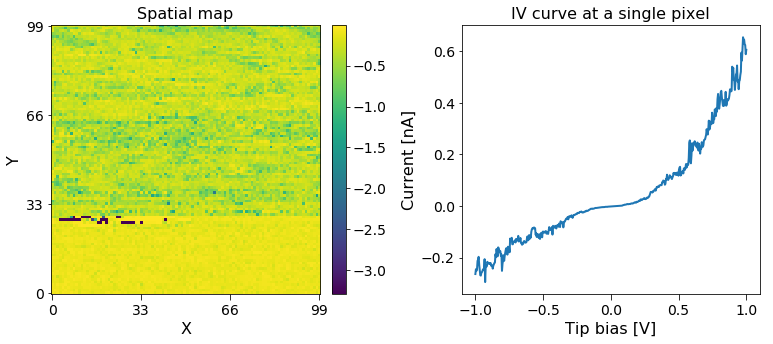

In [13]:
with h5py.File(h5_path, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    usid.hdf_utils.print_tree(h5_file)

    h5_main = h5_file['Measurement_000/Channel_000/Raw_Data']
    usid.plot_utils.use_nice_plot_params()
    fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
    spat_map = np.reshape(h5_main[:, 100], (100, 100))
    usid.plot_utils.plot_map(axes[0], spat_map, origin='lower')
    axes[0].set_title('Spatial map')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[1].plot(np.linspace(-1.0, 1.0, h5_main.shape[1]),
                 h5_main[250])
    axes[1].set_title('IV curve at a single pixel')
    axes[1].set_xlabel('Tip bias [V]')
    axes[1].set_ylabel('Current [nA]')

    fig.tight_layout()

# Remove both the original and translated files:
os.remove(h5_path)
os.remove(data_file_path)